# Model Calibration

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as ss
import seaborn as sns
import pandas as pd
import pickle
from patsy import dmatrices
import statsmodels as sm
import statsmodels.api as sma
sns.set()

In [5]:
def solve_for_x(y, res):
    """
    Used when getting parameters from a linear equation
    """
    c = res.params[0]
    m = res.params[1]
    
    return (y - c) / m

There are a large number of parameters that can be calibrated - we primarily are calibrating to the growth rate, however we have the ability to calibrate to a household secondary attack rate and corresponding growth rate.


Importantly this is the notebook that creates the calibration dictionary.

We prefer to tune our model to a given growth rate, without contact tracing. The growth rate depends upon a (hazard_rate_cale, infection_reporting_prob) pair and we use the simulation script "Simulate_growth_rates.py" to perform the growth rate simulations and return a data frame of the outputs. We analyse this data frame here.

In [8]:
data = pd.read_excel("Data/Calibration/growth_rates_hhSize1.xlsx", index_col = 0)
days_simulated = 20

In [9]:
data

,haz_rate_scale,infection_reporting_prob,0,1,2,3,4,5,6,7,...,10,11,12,13,14,15,16,17,18,19
0,0.2,0.1,1000,1002,1063,1241,1595,2122,2768,3503,...,6837,8403,10328,12746,15689,19260,23628,28803,35169,42998
1,0.2,0.2,1000,1003,1060,1241,1568,2063,2684,3417,...,6637,8163,10084,12251,15029,18190,22133,27003,32806,39885
2,0.2,0.3,1000,1002,1060,1240,1589,2095,2754,3483,...,6576,8051,9939,12104,14750,17807,21578,26122,31562,38360
3,0.2,0.4,1000,1007,1070,1241,1594,2096,2721,3448,...,6413,7886,9648,11718,14253,17181,20780,25087,30168,36512
4,0.2,0.5,1000,1004,1058,1265,1615,2111,2769,3511,...,6452,7894,9609,11574,13857,16727,20112,24130,28972,34807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,0.3,0.1,1000,1002,1074,1348,1885,2744,3857,5391,...,13193,17812,24003,32263,43435,58488,78449,105394,141290,189415
246,0.3,0.2,1000,1005,1087,1360,1920,2767,3920,5386,...,13241,17779,23954,32072,43008,57545,76852,102929,137448,183002
247,0.3,0.3,1000,1007,1088,1351,1863,2684,3794,5171,...,12487,16697,22387,30017,39662,53041,70388,93750,124474,165417
248,0.3,0.4,1000,1003,1094,1371,1953,2776,3876,5304,...,12621,16777,22358,29717,39565,52446,69638,92417,122576,162617


## Estimation of Growth Rates:

We fit a linear model to the epidemics and estimate the growth rate of the epidemic.

In [10]:
infection_counts = [str(i) for i in range(days_simulated)]
number_rows = data.shape[0]

In [11]:
data_subset = data[infection_counts]

In [12]:
growth_rates = []

for _ in range(data_subset.shape[0]):
    
    # Which row are we estiamting growth rate for
    print(f"current fit; {_}", end = "\r")
    
    # Difference the counts to get the incidence, take the log to get to the growth rate
    log_diff = data_subset.iloc[_].diff(1).apply(lambda x: np.log(x))

    # temporary dataframe to pass to the linear model
    data_set_up = {
        "log_case_incidence": log_diff[10:days_simulated],
        "time": list(range(10, days_simulated))
    }
    dataframe = pd.DataFrame(data_set_up)

    # Set up the regression
    y, X = dmatrices('log_case_incidence ~ time', 
                     data = dataframe)
    model = sma.RLM(y, X)
    res = model.fit()
    growth_rates.append(res.params[1])

    # Unable to handle missing data, where the epidemic has died out for example
    if res.params[1] == -float("inf"):
        print(f"missing data in line {_}")

In [13]:
growth_rate_data =pd.DataFrame({
    "growth_rate": growth_rates,
    "infection_reporting_prob": data["infection_reporting_prob"],
    "hazard_rate_scale": data["haz_rate_scale"]
})

In [14]:
y, X = dmatrices('growth_rate ~ hazard_rate_scale + infection_reporting_prob', 
                 data = growth_rate_data)
model_1 = sma.OLS(y, X)
res = model_1.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            growth_rate   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                 3.288e+04
Date:                Sat, 02 Jan 2021   Prob (F-statistic):          1.91e-300
Time:                        15:54:09   Log-Likelihood:                 1224.9
No. Observations:                 250   AIC:                            -2444.
Df Residuals:                     247   BIC:                            -2433.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

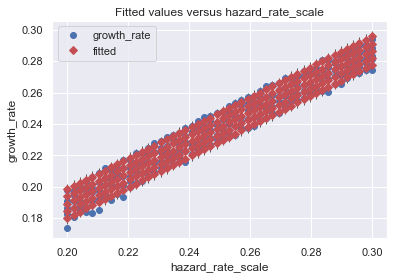

In [15]:
fig = sm.graphics.regressionplots.plot_fit(res, 1)

In [16]:
def solve_for_hazard_rate(results, infection_report_prob, growth_rate):
    """
    Sovles for the required hazard rate from the regression data.
    """
    intercept = res.params[0]
    beta_0 = res.params[1]
    beta_1 = res.params[2]
    hazard_rate_scale = (growth_rate - intercept - beta_1 * infection_report_prob) / beta_0
    return hazard_rate_scale

In [17]:
hazard_rate_getter = lambda infection_report_prob: solve_for_hazard_rate(res, infection_report_prob = infection_report_prob, growth_rate = 0.22)

In [18]:
infection_detect_probs = [0.1, 0.2, 0.3, 0.4, 0.5]
hazard_rates = map(hazard_rate_getter, infection_detect_probs)
hazard_rate_detection_prob_pairs = dict(zip(infection_detect_probs, hazard_rates))

In [19]:
hazard_rate_detection_prob_pairs

{0.1: 0.22225170046790374,
 0.2: 0.22692093912543568,
 0.3: 0.2315901777829676,
 0.4: 0.23625941644049953,
 0.5: 0.24092865509803146}

In [22]:
with open('Data/Calibration/hazard_rate_detection_prob_pairs.pickle', 'wb') as handle:
    pickle.dump(hazard_rate_detection_prob_pairs, handle, protocol=pickle.HIGHEST_PROTOCOL)

To load the data use the following:

In [23]:
with open('Data/Calibration/hazard_rate_detection_prob_pairs_hhSize1.pickle', 'rb') as handle:
    pairs_dict = pickle.load(handle)
